In [251]:
# Import necessary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from os import listdir
import re
import math

In [9]:
FILEPATH = 'ece661_pics\\hw7_image\\'

In [495]:
class Pattern():
    ''' 
        Class for handling pattern.
    '''
    P = 8
    ARRAY2VALUE = np.array([2**(7-i) for i in range(P)])

    def __init__(self, pattern):
        self.pattern = pattern 
        self.find_min_val()
    
    def __repr__(self):
        return  (f'Pattern = {self.pattern}\n'
                f'Min pattern = {self.min_pattarn}\n'
                f'Min Value = {self.min_value}\n')
    
    def find_min_val(self):
        ''' 
            Find the min value pattern.
        '''
        min_value = 2**self.P
        pattern = self.pattern.tolist()
        for i in range(self.P):
            pattern.append(pattern.pop(0))
            value = np.dot(self.ARRAY2VALUE, np.array(pattern))
            if value < min_value:
                self.min_value = value
                self.min_pattarn = pattern.copy()
                min_value = value

    def encode(self):
        '''
            Encode the pattern.
        '''
        if self.min_value == 0:
            return 0
        elif self.min_value == 2**self.P - 1:
            return self.P
        
        runs = 0
        ones = 0
        prev = self.min_pattarn[0]
        if prev == 1:
            ones += 1
            runs *= 1
        for i in range(1, self.P):
            current = self.min_pattarn[i]
            if prev != current:
                runs +=1 
            if runs > 2:
                return self.P + 1
            if current == 1:
                ones += 1
            prev = current
        return ones


In [499]:
class Image():
    ''' 
        Class for storing images.
    '''
    
    def __init__(self, name):
        self.name = name    
        self.image = None  
        self.hist = None

    def load(self):
        self.image = cv.imread(self.name)
        self.image_gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)

    def show(self):
        if self.image is None:
            self.load()
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))
    
    def extract_pattern(self, p=8, r=1):
        '''
            Extract histrogram pattern.
        '''
        if self.image is None:
            self.load()
        
        if self.hist is not None:
            return self.hist
        
        img = self.image_gray
        h, w = img.shape
        du = math.cos(2*math.pi/p)
        dv = math.sin(2*math.pi/p)
        # Compute linear interpolation
        # 1. Turn 3 x 3 to 9 x 1
        # 2. Dot product with 8 x 9 matrix below
        interpolation = np.array([
            [0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, (1-du)*(1-dv), (1-du)*(dv), 0, (du)*(1-dv), (dv)*(dv)],
            [0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, (du)*(1-dv), (dv)*(dv), 0, (1-du)*(1-dv), (1-du)*(dv), 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0],
            [(dv)*(dv), (du)*(1-dv), 0, (1-du)*(dv), (1-du)*(1-dv), 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, (1-du)*(dv), (1-du)*(1-dv), 0, (dv)*(dv), (du)*(1-dv), 0],
        ])

        patterns = []
        for i in range(1, w-1):
            for j in range(1, h-1):
                # Extract 3 x 3 kernal
                kernal = img[j-1:j+2, i-1:i+2]
                # Apply linear interpolation
                pattern = np.dot(interpolation, kernal.ravel().T)
                # Compare to center pixel
                pattern = pattern > kernal[1][1]
                pattern = Pattern(pattern.astype(np.uint8))
                # Use encode function of Pattern class define above
                patterns.append(pattern.encode())

        self.hist, self.bin_edges = np.histogram(patterns, bins=[i for i in range(p+3)], density=True)
        return self.hist

    def plot_histogram(self, savename=None):
        if self.hist is None:
            self.extract_pattern() 
        
        plt.bar(self.bin_edges[0:-1], self.hist)
        if savename is not None:
            savename = f'{FILEPATH}{savename}.png'
            plt.savefig(savename)


In [489]:
def load_image(img_classes):
    '''
        Load images from database.
    '''

    trainning_set = {}
    testing_set = {}
    
    for img_class in img_classes:
        trainning_set[img_class] = []
        testing_set[img_class] = []
        # Load training sets
        directory = f'{FILEPATH}training\\{img_class}'
        imgs = listdir(directory)
        for img in imgs:
            full_path = f'{directory}\\{img}'
            trainning_set[img_class].append(Image(full_path))

        # Load testing set
        directory = f'{FILEPATH}testing'
        imgs = listdir(directory)
        imgs_in_class = [re.findall(f'{img_class}.*', img) for img in imgs]
        for img in imgs_in_class:
            if img:
                full_path = f'{directory}\\{img[0]}'
                testing_set[img_class].append(Image(full_path))
        

    return trainning_set, testing_set

In [500]:
img_classes = ['beach', 'building', 'car', 'mountain', 'tree']
[imgs_train, imgs_test] = load_image(img_classes)

In [509]:
for class_idx_test, img_class_test in enumerate(img_classes):
    for img_test in imgs_test[img_class_test]:
        print(img_test.name) # Image under test
        distances = [] # Distance to each train image
        indiecs = [] # Class index of each train image
        for class_idx_train, img_class_train in enumerate(img_classes):
            for img_train in imgs_train[img_class_train]:
                distance = np.linalg.norm(img_train.extract_pattern() - img_test.extract_pattern())
                distances.append(distance)
                indiecs.append(class_idx_train)
        distances = np.array(distances)
        indiecs = np.array(indiecs)
        min_distances = np.sort(distances) # Sorting distance array
        min_distances_idx = np.where(distances < min_distances[5]) # Find 5 least distance
        # Get Class index of most common class of 5 least distance
        predicted = np.bincount(indiecs[min_distances_idx]).argmax()  
        print(f'Ground Truth class {img_classes[class_idx_test]}. Predicted class {img_classes[predicted]}\n')


ece661_pics\hw7_image\testing\beach_1.jpg
Ground Truth class beach. Predicted class beach

ece661_pics\hw7_image\testing\beach_2.jpg
Ground Truth class beach. Predicted class tree

ece661_pics\hw7_image\testing\beach_3.jpg
Ground Truth class beach. Predicted class beach

ece661_pics\hw7_image\testing\beach_4.jpg
Ground Truth class beach. Predicted class building

ece661_pics\hw7_image\testing\beach_5.jpg
Ground Truth class beach. Predicted class beach

ece661_pics\hw7_image\testing\building_1.jpg
Ground Truth class building. Predicted class mountain

ece661_pics\hw7_image\testing\building_2.jpg
Ground Truth class building. Predicted class building

ece661_pics\hw7_image\testing\building_3.jpg
Ground Truth class building. Predicted class beach

ece661_pics\hw7_image\testing\building_4.jpg
Ground Truth class building. Predicted class beach

ece661_pics\hw7_image\testing\building_5.jpg
Ground Truth class building. Predicted class building

ece661_pics\hw7_image\testing\car_1.jpg
Ground Tr

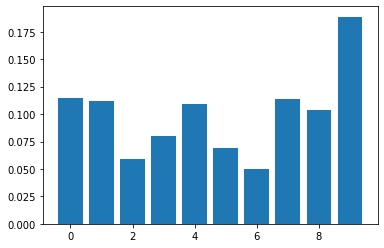

In [508]:
imgs_train['tree'][4].plot_histogram('histrogram_tree')
# img = img_train['beach'][0].image_gray